# EnvErgo project
- [researchgate link](https://www.researchgate.net/project/Isokinetic-measurements-and-musculoskeletal-modelling-for-ergonomics)
- [github link](https://github.com/romainmartinez/envergo)

_Romain Martinez_

# Statistical Parametric Mapping

## Todos
- Region of interest in spm

## Data description
- 3 files for each position:
    1. `participant_position_CVP`: `Couple_ext`, `Couple_flex`, `Position`, `Vitese` (441, 1 each)
    2. `participant_position_Flex_meshdata`: `Angle4mesh` (1, 21), `Velocity4mesh` (1, 21), `torque4mesh`(21, 21)
    3. `participant_position_Ext_meshdata`: `Angle4mesh` (1, 21), `Velocity4mesh` (1, 21), `torque4mesh` (21, 21)
- We will use `Angle4mesh` (1, 21), `Velocity4mesh` (1, 21), `torque4mesh`(21, 21) to generate mesh and do the stats

In [2]:
import envergo
import os
import scipy.io as sio
import numpy as np
import spm1d
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_path = '/home/romain/Desktop/envergo'
files = os.listdir(data_path)

torque = {}

for ifile in files:
    if ifile.endswith('meshdata.mat'):
        participant, position, contraction, ext = ifile.split('_')

        mat = sio.loadmat(os.path.join(data_path, ifile))['Torque4mesh']
        if not position in torque:
            torque[position] = {}
        if contraction in torque[position]:
            torque[position][contraction] = np.dstack((torque[position][contraction], mat))
        else:
            torque[position][contraction] = mat

In [4]:
# create spm matrix
angle, velocity, participant = torque['Abd90ER']['Ext'].shape
position = len(torque.keys())

participants, positions, y = ([] for i in range(3))

for iparticipant in range(participant):
    for iposition, position_name in enumerate(torque.keys()):
        participants.append(iparticipant + 1)
        positions.append(iposition + 1)
        y.append(torque[position_name]['Ext'][:, :, iparticipant].flatten())

participants, positions, y = [np.array(i) for i in [participants, positions, y]]
print('participant: {}'.format(participants))
print('position: {}'.format(positions))
print('y.shape: {}'.format(y.shape))

participant: [1 1 1 1 1 1 2 2 2 2 2 2]
position: [1 2 3 4 5 6 1 2 3 4 5 6]
y.shape: (12, 441)


## One-way repeated-measures ANOVA (non-parametric)

SnPM{F} inference field
   SPM.effect         :  Main A
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  4.79e+08 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  20.38976
   SPM.h0reject       :  False
   SPM.p              :  ()



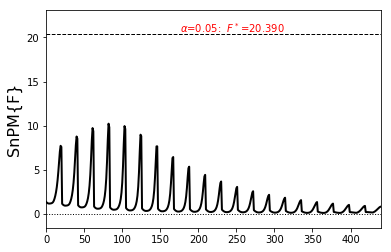

In [5]:
alpha = 0.05
spm = spm1d.stats.nonparam.anova1rm(y, positions, participants)
spmi = spm.inference(alpha, iterations=10000)
print(spmi)

f = plt.figure()
spmi.plot()
spmi.plot_p_values()
spmi.plot_threshold_label()
plt.show()

In [6]:
# reshape to visualize the results in their original 2D context
z = spmi.z.reshape([21, 21])
zstar = spmi.zstar
#z[z < zstar] = np.nan

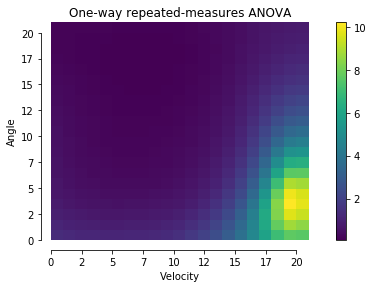

In [9]:
plt.pcolor(z, cmap='viridis')

# float to int
envergo.util.axis2int()

# aes
sns.despine(offset=10, trim=True)

# add color bar
plt.colorbar(pad=.08)

plt.xlabel('Velocity')
plt.ylabel('Angle')
plt.title('One-way repeated-measures ANOVA')
plt.show()

## Post hoc analysis (paired t-test)